In [3]:
import pandas as pd

df = pd.read_csv("household_power_consumption.csv")
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [4]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44014 entries, 0 to 44013
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   44014 non-null  object 
 1   Time                   44014 non-null  object 
 2   Global_active_power    44013 non-null  object 
 3   Global_reactive_power  44013 non-null  object 
 4   Voltage                44013 non-null  object 
 5   Global_intensity       44013 non-null  object 
 6   Sub_metering_1         44013 non-null  object 
 7   Sub_metering_2         44013 non-null  object 
 8   Sub_metering_3         44008 non-null  float64
dtypes: float64(1), object(8)
memory usage: 3.0+ MB


,0
Date,0
Time,0
Global_active_power,1
Global_reactive_power,1
Voltage,1
Global_intensity,1
Sub_metering_1,1
Sub_metering_2,1
Sub_metering_3,6


In [5]:
df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)


In [6]:
for col in df.columns:
    if col not in ["Date", "Time"]:
        df[col] = df[col].astype(float)


In [7]:
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df.drop(["Date", "Time"], axis=1, inplace=True)


/tmp/ipython-input-3515553760.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])


In [8]:
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.weekday

df.drop("datetime", axis=1, inplace=True)


In [9]:
y = df["Global_active_power"]
X = df.drop("Global_active_power", axis=1)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(name)
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2:", r2_score(y_test, y_pred))
    print("-"*30)

evaluate(lr, "Linear Regression")
evaluate(rf, "Random Forest")


Linear Regression
RMSE: 0.060640698965186805
R2: 0.9980694478423358
------------------------------
Random Forest
RMSE: 0.03425954383039244
R2: 0.9993838076610774
------------------------------


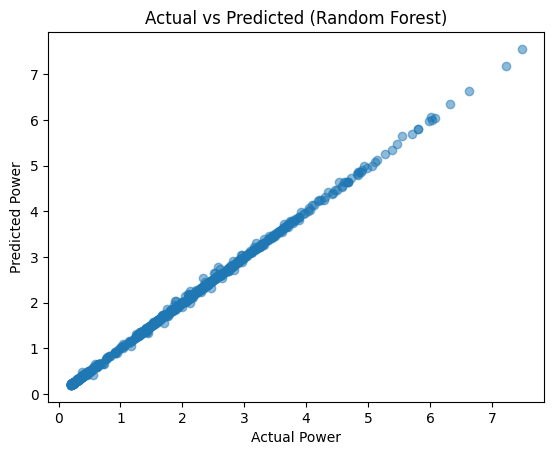

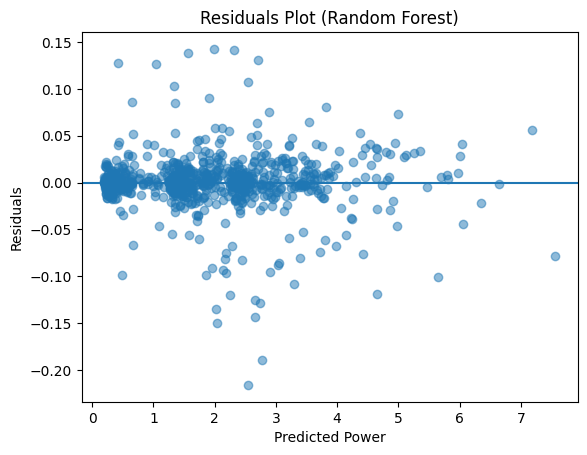

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test)

# -------- Actual vs Predicted (Random Forest) --------
plt.figure()
plt.scatter(y_test[:1000], y_pred_rf[:1000], alpha=0.5)
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()

# -------- Residuals Plot (Random Forest) --------
residuals = y_test - y_pred_rf

plt.figure()
plt.scatter(y_pred_rf[:1000], residuals[:1000], alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Power")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Random Forest)")
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_best = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("Tuned RF RMSE:", rmse)
print("Tuned RF R2:", r2)


Tuned RF RMSE: 0.03404005328890488
Tuned RF R2: 0.9993916778850956


In [17]:
import joblib

# If using your original RF model
joblib.dump(rf, "household_power_model.pkl")

# OR if using tuned model
# joblib.dump(best_rf, "household_power_model.pkl")

print("Model saved as household_power_model.pkl")


Model saved as household_power_model.pkl


In [18]:
import pandas as pd
import joblib

# Load saved model
model = joblib.load("household_power_model.pkl")

# Sample input data (1 row)
sample_data = pd.DataFrame({
    "Global_reactive_power": [0.15],
    "Voltage": [234.5],
    "Global_intensity": [6.2],
    "Sub_metering_1": [0.0],
    "Sub_metering_2": [1.0],
    "Sub_metering_3": [12.0],
    "hour": [18],
    "day": [15],
    "month": [7],
    "weekday": [3]
})

# Make prediction
prediction = model.predict(sample_data)[0]
print("Predicted Global Active Power:", prediction)


Predicted Global Active Power: 1.4432599999999995
